In [1]:
import pickle
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import ruptures as rpt

In [2]:
data = xr.open_dataset('../../_1_in_situ_data/all_data_qc_final.nc')

with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/OUTPUT/testing_output/predictions_s1_xg.p', 'rb') as fp:
    df = pickle.load(fp)

df.loc[df.sc_percum <= 0.25, 'prediction_label'] = 0

In [3]:
df.loc[df.sd_insitu == 0, 'sd_insitu'] = np.nan
df = df.dropna()

In [4]:
years = [2015,2016,2017,2018,2019,2020,2021,2022]

In [5]:
insitu, insitu_time = list(), list()
ml, ml_time = list(), list()
hans, hans_time = list(), list()

for y in years:
    data_year = data.sel(time = slice(f'{y}0901', f'{y+1}0531'))
    df_year = df.loc[(df.time>pd.Timestamp(y, 9, 1))&(df.time<pd.Timestamp(y+1, 6, 1))]
    for s in data.site.values:
        
        data_s = data_year.sel(site = s)
        site_df = df_year.loc[df_year.site==s]
        if len(site_df) > 10:
            site_df = site_df.sort_values(by = 'time').reset_index()  
            site_df = site_df.groupby(site_df.time).mean()
            site_df = site_df.reindex(pd.date_range(start = f"{y}-09-01",end = f"{y+1}-05-31", freq = '1D'))
            site_df = site_df.rolling(window = 6, center = True, min_periods = 1).mean()
            
            sd_max = data_s.sd_insitu.max()
            sd_max10 = sd_max - sd_max*0.1
            sd_max_loc = data_s.where(data_s.sd_insitu >=sd_max10).dropna(dim = 'time')
            last = sd_max_loc.isel(time = -1).time.values
            first = pd.Timestamp(last) - pd.Timedelta(days = 14)
            sd_max2 = data_s.sel(time = slice(first,last)).sd_insitu.max()
            day = data_s.where(data_s.sd_insitu ==sd_max2).dropna(dim = 'time').time.values[-1]
            dos = (day - pd.Timestamp(y,8,1)).days
            
            sd_max_ml = site_df.prediction_label.max()
            sd_max_ml10 = sd_max_ml - sd_max_ml*0.1
            sd_max_loc_ml = site_df.loc[site_df.prediction_label >=sd_max_ml10]
            last_ml = sd_max_loc_ml.iloc[-1].DayOfSeason
            first_ml = last_ml-14
            sd_max2_ml = site_df.loc[(site_df.DayOfSeason>=first_ml)&(site_df.DayOfSeason<=last_ml)].prediction_label.max()
            dos_ml = site_df.loc[site_df.prediction_label == sd_max2_ml].iloc[-1].DayOfSeason
            
            sd_max_h = site_df.sd_hans.max()
            sd_max_h10 = sd_max_h - sd_max_h*0.1
            sd_max_loc_h = site_df.loc[site_df.sd_hans >=sd_max_h10]
            last_h = sd_max_loc_h.iloc[-1].DayOfSeason
            first_h = last_h-14
            sd_max2_h = site_df.loc[(site_df.DayOfSeason>=first_h)&(site_df.DayOfSeason<=last_h)].sd_hans.max()
            dos_h = site_df.loc[site_df.sd_hans == sd_max2_h].iloc[-1].DayOfSeason
            
            insitu.append(sd_max2)
            ml.append(sd_max2_ml)
            hans.append(sd_max2_h)
            
            if sd_max2 > 0.5:
                # plt.figure()
                # plt.plot(site_df.prediction_label, '.-')
                # plt.plot(site_df.sd_hans, '.-')
                # plt.plot(data_s.time, data_s.sd_insitu, '.-')
                # plt.show()
                insitu_time.append(dos)
                ml_time.append(dos_ml)
                hans_time.append(dos_h)
                #print(dos, dos_ml, dos_h)

In [6]:
def prepare_panel(ax, xlabel, ylabel):
    ax.set_xlim([0,6.3])
    ax.set_ylim([0,6.3])
    ax.plot([0,6.3],[0,6.3], 'k-', alpha = 0.75)
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([0,1,2,3,4,5,6])
    ax.set_xticklabels([0,'',2,'',4,'',6])
    ax.set_yticklabels([0,'',2,'',4,'',6])
    ax.set_xlabel(xlabel, fontsize = 28)
    ax.set_ylabel(ylabel, fontsize = 28)
    ax.grid()
    ax.tick_params(axis='x', labelsize=24)  # Font size for x-axis tick labels
    ax.tick_params(axis='y', labelsize=24)  # Font size for y-axis tick labels
    

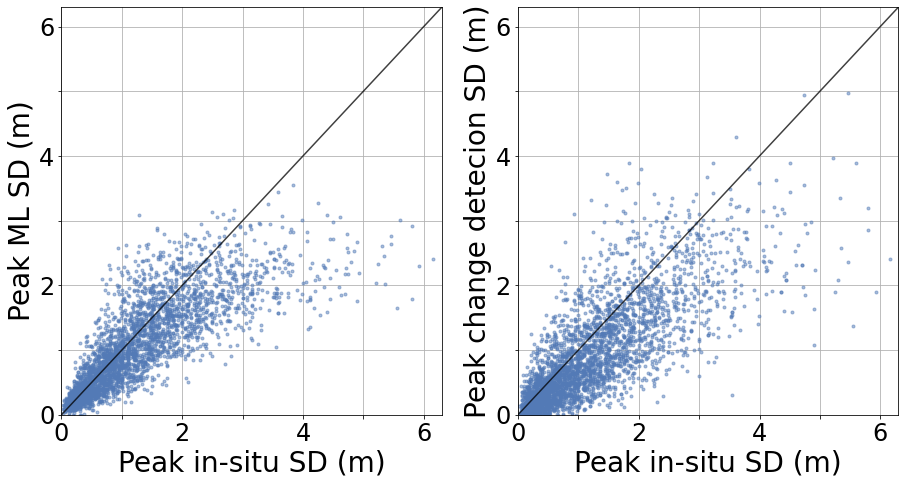

In [7]:
fig, ax = plt.subplots(1,2,figsize = (15,7.5))
ax[0].plot(insitu, ml,'.', color = '#537ab6ff', alpha = 0.5)
prepare_panel(ax[0], 'Peak in-situ SD (m)', 'Peak ML SD (m)')

ax[1].plot(insitu, hans,'.', color = '#537ab6ff', alpha = 0.5)
prepare_panel(ax[1], 'Peak in-situ SD (m)', 'Peak change detecion SD (m)')
plt.savefig('peak_sd.png', dpi = 300, bbox_inches = 'tight')

In [8]:
insitu = np.asarray(insitu)
ml = np.asarray(ml)
hans = np.asarray(hans)

In [9]:
#Snow depth
x = np.arange(0.25,6.5,0.25)
re_ml_sd, re_hans_sd, n_sd = list(), list(), list()

for item in x:
    ml1 = ml[(insitu>=item)&(insitu<item+0.25)]
    h1 = hans[(insitu>=item)&(insitu<item+0.25)]
    is1 = insitu[(insitu>=item)&(insitu<item+0.25)]
    
    re_ml_sd.append(np.abs(ml1-is1).mean()/is1.mean())
    re_hans_sd.append(np.abs(h1-is1).mean()/is1.mean())
    n_sd.append(len(ml1))
    
re_ml_sd = np.asarray(re_ml_sd)
re_hans_sd = np.asarray(re_hans_sd)
n_sd = np.asarray(n_sd)

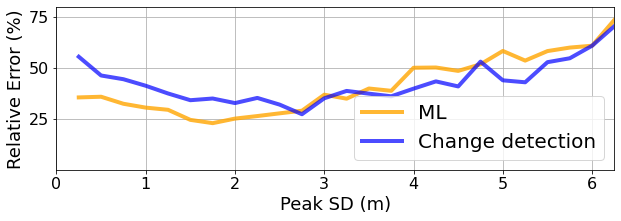

In [10]:
fig, ax = plt.subplots(1,1,figsize = (10,3))
ax.plot(x, 100*re_ml_sd, color = 'orange',alpha = 0.8, label = 'ML', linewidth = 4)
ax.plot(x, 100*re_hans_sd, color = 'blue',alpha = 0.7, label = 'Change detection', linewidth = 4)
ax.legend(fontsize = 20, loc = 'lower right')
ax.grid()
ax.set_ylim([0, 80])
ax.set_xlim([0,6.25])
ax.set_yticks([25,50,75])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('Peak SD (m)', fontsize = 18)
ax.set_ylabel('Relative Error (%)', fontsize = 18)
plt.savefig('peak_sd_bins.png', dpi = 300, bbox_inches = 'tight')

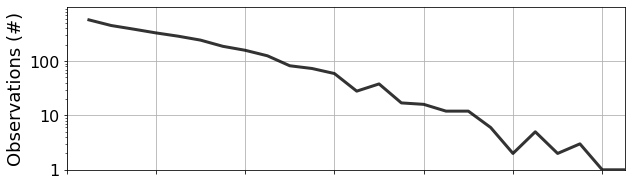

In [11]:
fig, ax = plt.subplots(1,1,figsize = (10,3))
ax.plot(x, n_sd, color = 'k',alpha = 0.8, linewidth = 3)
ax.grid()
ax.set_yscale('log')
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim([1,1000])
ax.set_xticklabels([])
ax.set_ylabel('Observations (#)',fontsize = 18)
ax.set_xlim([0,6.25])
plt.savefig('peak_sd_n.png', dpi = 300, bbox_inches = 'tight')

In [12]:
ml2 = stats.linregress(insitu, ml)
hans2 = stats.linregress(insitu, hans)

print(ml2)
print(hans2)

def rmse_fun(o, p):
    """Calculate the root mean squared error between predictions and targets"""
    return np.sqrt(np.mean((p - o) ** 2))

print(np.abs(np.asarray(insitu)- np.asarray(ml)).mean())
print(np.abs(np.asarray(insitu)- np.asarray(hans)).mean())
#print(rmse_fun(np.asarray(insitu), np.asarray(hans)))

LinregressResult(slope=0.5916334732535543, intercept=0.2997185883792801, rvalue=0.8125445317664569, pvalue=0.0, stderr=0.007234250316945224, intercept_stderr=0.011240071415929268)
LinregressResult(slope=0.6216528768658202, intercept=0.15850633587257967, rvalue=0.7777647132052949, pvalue=0.0, stderr=0.00856323631244417, intercept_stderr=0.013304956766272767)
0.3839069939923764
0.4740018298883426


In [13]:
print(np.mean(ml[insitu>3]-insitu[insitu>3]))
print(np.mean(hans[insitu>3]-insitu[insitu>3]))

-1.6326161775627106
-1.4767238594100591


In [14]:
diff_hans, diff_ml= list(), list()
for i in range(len(insitu_time)):
    diff_ml.append((insitu_time[i] - ml_time[i]))
    diff_hans.append((insitu_time[i] - hans_time[i]))
    
diff_ml = np.asarray(diff_ml)
diff_hans = np.asarray(diff_hans)


In [15]:
x, x2 = list(), list()
for dt in range(0,100):
    ml_week = diff_ml[(diff_ml<=dt)&(diff_ml>=-dt)]
    hans_week = diff_hans[(diff_hans<=dt)&(diff_hans>=-dt)]

    x.append(len(ml_week)/len(diff_ml))
    x2.append(len(hans_week)/len(diff_hans))

x= np.asarray(x)
x2 = np.asarray(x2)

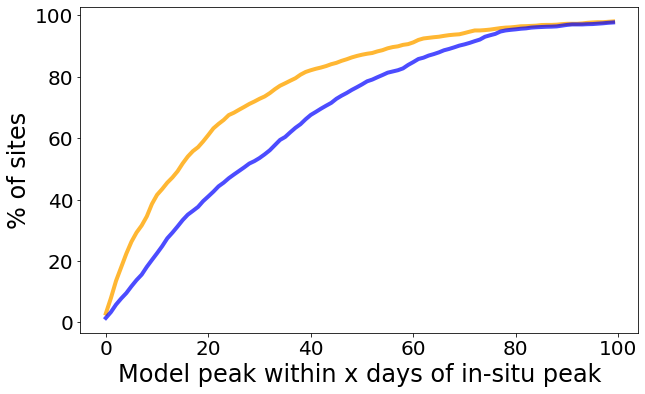

In [16]:
fig, ax = plt.subplots(1,1,figsize = (10,6))

ax.plot(np.arange(100), x*100, color = 'orange', linewidth = 4, alpha = 0.8)
ax.plot(np.arange(100), x2*100, color = 'blue', linewidth = 4, alpha = 0.7)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('Model peak within x days of in-situ peak', fontsize = 24)
ax.set_ylabel('% of sites', fontsize = 24)
plt.savefig('peak_sd_timing.png', dpi = 300, bbox_inches = 'tight')

In [23]:
np.mean(np.array(insitu_time) - np.array(hans_time))

-14.03389490573606

In [24]:
np.mean(np.array(insitu_time) - np.array(ml_time))

-11.07721620537505

In [6]:
insitu, insitu_time = list(), list()
ml, ml_time = list(), list()
hans, hans_time = list(), list()

for y in [2017]:
    data_year = data.sel(time = slice(f'{y}0901', f'{y+1}0531'))
    df_year = df.loc[(df.time>pd.Timestamp(y, 9, 1))&(df.time<pd.Timestamp(y+1, 6, 1))]
    for s in [70]:#data.site.values:
        
        data_s = data_year.sel(site = s)
        site_df = df_year.loc[df_year.site==s]
        if len(site_df) > 10:
            site_df = site_df.sort_values(by = 'time').reset_index()  
            site_df = site_df.groupby(site_df.time).mean()
            site_df = site_df.reindex(pd.date_range(start = f"{y}-09-01",end = f"{y+1}-05-31", freq = '1D'))
            site_df = site_df.rolling(window = 6, center = True, min_periods = 1).mean()
            
            sd_max = data_s.sd_insitu.max()
            sd_max10 = sd_max - sd_max*0.1
            sd_max_loc = data_s.where(data_s.sd_insitu >=sd_max10).dropna(dim = 'time')
            last = sd_max_loc.isel(time = -1)
            last_dos = (last.time.values - pd.Timestamp(y,9,1)).days
            first = last_dos-14
            sd_max2 = data_s.isel(time = slice(first,last_dos+1)).sd_insitu.max()
            day = data_s.where(data_s.sd_insitu ==sd_max2).dropna(dim = 'time').time.values[-1]
            dos = (day - pd.Timestamp(y,9,1)).days
            abs_max = data_s.where(data_s.sd_insitu==sd_max).dropna(dim = 'time')
            lateseason_max = data_s.where(data_s.sd_insitu==sd_max2).dropna(dim = 'time')
            
            sd_max_ml = site_df.prediction_label.max()
            sd_max_ml10 = sd_max_ml - sd_max_ml*0.1
            sd_max_loc_ml = site_df.loc[site_df.prediction_label >=sd_max_ml10]
            last_ml = sd_max_loc_ml.iloc[-1].DayOfSeason
            first_ml = last_ml-14
            sd_max2_ml = site_df.loc[(site_df.DayOfSeason>=first_ml)&(site_df.DayOfSeason<=last_ml)].prediction_label.max()
            dos_ml = site_df.loc[site_df.prediction_label == sd_max2_ml].iloc[-1].DayOfSeason
            
            sd_max_h = site_df.sd_hans.max()
            sd_max_h10 = sd_max_h - sd_max_h*0.1
            sd_max_loc_h = site_df.loc[site_df.sd_hans >=sd_max_h10]
            last_h = sd_max_loc_h.iloc[-1].DayOfSeason
            first_h = last_h-14
            sd_max2_h = site_df.loc[(site_df.DayOfSeason>=first_h)&(site_df.DayOfSeason<=last_h)].sd_hans.max()
            dos_h = site_df.loc[site_df.sd_hans == sd_max2_h].iloc[-1].DayOfSeason



/tmp/ipykernel_32939/2990764674.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Nov', 'Dec','Jan','Feb','Mar','Apr','May','May','Jun'])


[Text(17471.0, 0, 'Nov'),
 Text(17501.0, 0, 'Dec'),
 Text(17532.0, 0, 'Jan'),
 Text(17563.0, 0, 'Feb'),
 Text(17591.0, 0, 'Mar'),
 Text(17622.0, 0, 'Apr'),
 Text(17652.0, 0, 'May'),
 Text(17683.0, 0, 'May')]

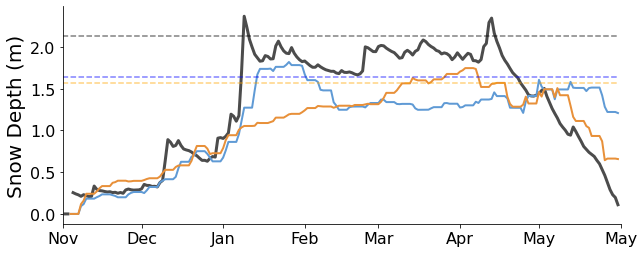

In [22]:
fig, ax = plt.subplots(1,1,figsize = (10,4))

ax.plot(data_s.time, data_s.sd_insitu, 'k', alpha = 0.7, label = 'In-situ SD', linewidth = 3)
ax.plot([data_s.time.values[0], data_s.time.values[-1]], [sd_max10,sd_max10], 'k--', alpha = 0.5, label = '90% of peak SD')

ax.plot(site_df.sd_hans, color = '#5f9ad5', label = '6-day smoothed empirical SD', linewidth = 2)
ax.plot(site_df.prediction_label, color =  '#e89039', label = '6-day smoothed ML SD', linewidth = 2)

ax.plot([data_s.time.values[0], data_s.time.values[-1]], [sd_max_h10,sd_max_h10], 'b--', alpha = 0.5)
ax.plot([data_s.time.values[0], data_s.time.values[-1]], [sd_max_ml10,sd_max_ml10], '--', color = 'orange', alpha = 0.5)


# ax.scatter(abs_max.time.values, abs_max.sd_insitu.values,s = 75, c = 'w', edgecolor = 'k', label = 'In-situ absolute peak SD')
# ax.scatter(lateseason_max.time.values, lateseason_max.sd_insitu.values,s = 75, c = 'k', label = 'In-situ late-season relative peak SD')
# ax.scatter(site_df.loc[site_df.sd_hans == sd_max2_h].reset_index().iloc[0].level_0,\
#             site_df.loc[site_df.sd_hans == sd_max2_h].reset_index().iloc[0].sd_hans, color = 'blue',\
#            edgecolor = 'k', s = 75, label = 'Empirical late-season relative peak SD')
# ax.scatter(site_df.loc[site_df.prediction_label == sd_max2_ml].reset_index().iloc[0].level_0,\
#             site_df.loc[site_df.prediction_label == sd_max2_ml].reset_index().iloc[0].prediction_label, color = 'orange',\
#            edgecolor = 'k', s = 75, label = 'ML late-season relative peak SD')

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim([pd.Timestamp(2017,11,1),pd.Timestamp(2018,6,1)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Snow Depth (m)', fontsize = 20)
ax.set_xticklabels(['Nov', 'Dec','Jan','Feb','Mar','Apr','May','May','Jun'])
#ax.legend(fontsize = 12)

#plt.savefig('peak_sd2.png', dpi = 150, bbox_inches = 'tight')

70


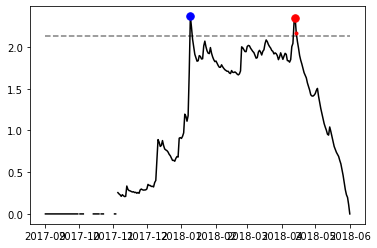

In [89]:
for s in [70]:#data.site.values:
    data_s = data.isel(site = s).sel(time = slice('2017-09-01','2018-06-01'))
    if data_s.sd_insitu.max() > 1.5:
        print(s)
        
        sd_max = data_s.sd_insitu.max()
        abs_max = data_s.where(data_s.sd_insitu==sd_max).dropna(dim = 'time')
        sd_max10 = sd_max - sd_max*0.1
        sd_max_loc = data_s.where(data_s.sd_insitu >=sd_max10).dropna(dim = 'time')
        last = sd_max_loc.isel(time = -1)#.time.values
        
        last_dos = (last.time.values - pd.Timestamp(2017,9,1)).days
        first = last_dos-14
        sd_max2 = data_s.isel(time = slice(first,last_dos+1)).sd_insitu.max()
                abs_max = data_s.where(data_s.sd_insitu==sd_max).dropna(dim = 'time')

        lateseason_max = data_s.where(data_s.sd_insitu==sd_max2).dropna(dim = 'time')
        
        plt.plot(data_s.time, data_s.sd_insitu, 'k')
        plt.plot(abs_max.time, abs_max.sd_insitu,'b.', markersize = 15)
        plt.plot([data_s.time.values[0], data_s.time.values[-1]], [sd_max10,sd_max10], 'k--', alpha = 0.5)
        plt.plot(last.time, last.sd_insitu,'r.')
        plt.plot(lateseason_max.time, lateseason_max.sd_insitu,'r.', markersize = 15)



        plt.show()
    

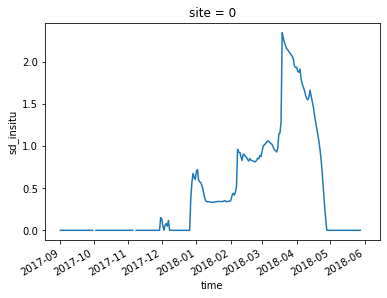

In [74]:
c.sd_insitu.plot()
